# An Exercise on transformers and embedding visualization for sentiment analysis

From IMDB dataset, we use a pre-trained `distilbert-base-uncased-finetuned-sst-2-english` model to extract the embeddings of the comments, evaluate the performance on sentiment analysis (in terms of ACC and F1 score), then use tSNE to visulize the embeddings.

Here's a summary of the key steps performed in this notebook:

*   Loaded and preprocessed the IMDB dataset.
*   Loaded the pre-trained DistilBERT model and tokenizer.
*   Extracted embeddings and obtained sentiment predictions using the model.
*   Evaluated the model's performance (Accuracy, F1 score, Confusion Matrix).
*   Visualized the comment embeddings using t-SNE.
*   Identified and examined misclassified instances.

In [ ]:
# Install dependencies
!pip install --upgrade datasets evaluate transformers[sentencepiece] fsspec huggingface_hub

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [ ]:
# Load Model and Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm


# Load IMDb dataset
dataset = load_dataset("imdb")

# Load model and tokenizer
# Use pretrained model (no extra training on current dataset)
ckpt = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = AutoModelForSequenceClassification.from_pretrained(ckpt)
print(model)

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Peep into the dataset
The IMDB dataset has three columns, `train`, `test` and `unsupervised`. For the first two columns, both text and its label (0 for negative, 1 for positive) are provided. The `unsupervised` column contains unlabeled texts (each instance is labeled `-1`).

In [ ]:
print(dataset)
# unsupervised one didn't have valid labels (all are -1)
print("An Instance inside IMDB dataset (test): \n", dataset['test'][42])
print("An Instance inside IMDB dataset (unsupervised):")
dataset['unsupervised'][42]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
An Instance inside IMDB dataset (test): 
 {'text': "I have no idea how anyone can give this movie high marks. I didn't rent it thinking it was the next great horror flick, the next great horror spoof, or the next great low-budget horror spoof. Obviously, this isn't meant to scare, but one fatal flaw with the production entirely sapped the joy out of the viewing experience. The sound editing was horrible. I had to work the volume control the entire movie. You can imagine how difficult it is to get into something - even a low-budget spoof - when you're either turning the volume up or down, or trying to anticipate the next time you have to do so. The regular dialogue is very low, and all screams, noises,

{'text': 'Let me say straight away that this movie is toxic waste for the mind. This movie is not watchable because it has a good story; it doesn\'t. It\'s not watchable because there\'s good acting; there is none. It\'s watchable because of the cast. This will take you down TV memory lane...how many former TV stars can you pick out?<br /><br />As with any TV "Movie of the Week", the drawing power is in the stars. The story involves the inaugural flight of "Maiden One" the first supersonic transport plane. (The movie ignores the fact that it was a British-French conglomerate that first built the Concorde, and had to sue for the right to land in America during this time.) In this movie, we have a disgruntled worker who sabotages the flight by putting detergent in the hydraulic lines in order to get revenge on his boss (Burgess Meredith).<br /><br />We also have Doug McClure trying to get back into Tina Louise\'s pants, Billy Crystal playing a rather fey steward, John Delancie in trainin

## Preprocessing
Parse the html text objects, and tokenize the input text.

In [ ]:
import re
import html

def clean_text(text):
    # Unescape HTML character entities (e.g. &quot; -> ")
    text = html.unescape(text)
    # Replace <br /> and <br> tags with newlines
    text = re.sub(r'<br\s*/?>', '\n', text)
    # Remove other HTML tags
    text = re.sub(r'<.*?>', '', text)
    return text
# map the dataset
dataset = dataset.map(lambda x: {"text": [clean_text(t) for t in x['text']]}, batched=True)

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

# tokenize all datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# Rename labels to fit the PyTorch dataset format
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

This function extract the embeddings of the sentence (the [CLS] token), the sentiment prediction, and the confidence score of the predictions.

In [ ]:
def extract_embeddings_and_predictions(dataset, model, tokenizer, device, batch_size=8):
    # Remove text to make DataLoader has the same shape in each batch.
    dataset = dataset.remove_columns(["text"])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    model.to(device)
    model.eval()

    all_embeddings = []
    all_predictions = []
    all_confidences = []

    with torch.no_grad():
        for batch in dataloader:

            allowed_keys = {"input_ids", "attention_mask"}
            # batch.items() is dict, we only need to extract required keys
            inputs = {k: v.to(device) for k, v in batch.items() if k in allowed_keys}
            outputs = model(**inputs, output_hidden_states = True)

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            # Get probability scores for confidence
            # the maximum value of the softmax score
            probs = torch.softmax(logits, dim=-1)
            confidence_scores = torch.max(probs, dim=-1).values  # Max probability as confidence

            cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # CLS token from last hidden state

            all_predictions.append(preds.cpu())
            all_embeddings.append(cls_embeddings.cpu())
            all_confidences.append(confidence_scores.cpu())

    predictions_tensor = torch.cat(all_predictions, dim=0)
    embeddings_tensor = torch.cat(all_embeddings, dim=0)
    confidences_tensor = torch.cat(all_confidences, dim=0)

    return predictions_tensor.numpy(), embeddings_tensor.numpy(), confidences_tensor.numpy()


sample_prop = 0.1
# only extract a small sample from test set
tokenized_sample = tokenized_datasets['test'].train_test_split(
    train_size=sample_prop, shuffle=True, seed=42
)["train"]
# extract the predictions and embeddings
preds, embs, confidences = extract_embeddings_and_predictions(
    tokenized_sample, model = model, tokenizer = tokenizer, device = device
)

## Sentiment analysis results
- Accuracy and F-1 score
- Confusion matrix

Since the dataset in balanced, the performance b/t two categories (Hit and Correct Reject) are similar. Both Accuracy and F-1 Score have great performance even though the model are not trained by the current dataset.

In [ ]:
import evaluate
# Load accuracy and f1 metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Collect predictions and references
references = tokenized_sample['labels']

# Compute metrics
accuracy_result = accuracy_metric.compute(predictions=preds, references=references)
f1_result = f1_metric.compute(predictions=preds, references=references)

print(f"Accuracy on sampled dataset: {accuracy_result['accuracy']:.4f}")
print(f"F1 Score on sampled dataset: {f1_result['f1']:.4f}")

Accuracy on sampled dataset: 0.8852
F1 Score on sampled dataset: 0.8871


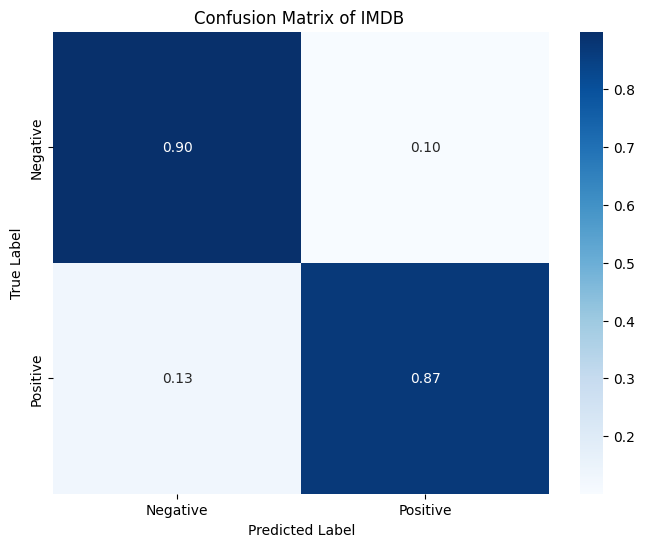

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract true labels and prediction
labels = np.array(tokenized_sample['labels'])
# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix to show proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of IMDB ")
plt.savefig("confusion_matrix.png")
plt.show()

# Save the figure

### t-SNE to visualize the embeddings

To investigate if comments with same sentiment labels have similar embeddings structures, we perform t-SNE to visualize these data.

From the plot below, one can see the Negative and Positive labels are generally spearated, as an U shape in the 2-D dimentions.

Shape of extracted embeddings: (2500, 768)


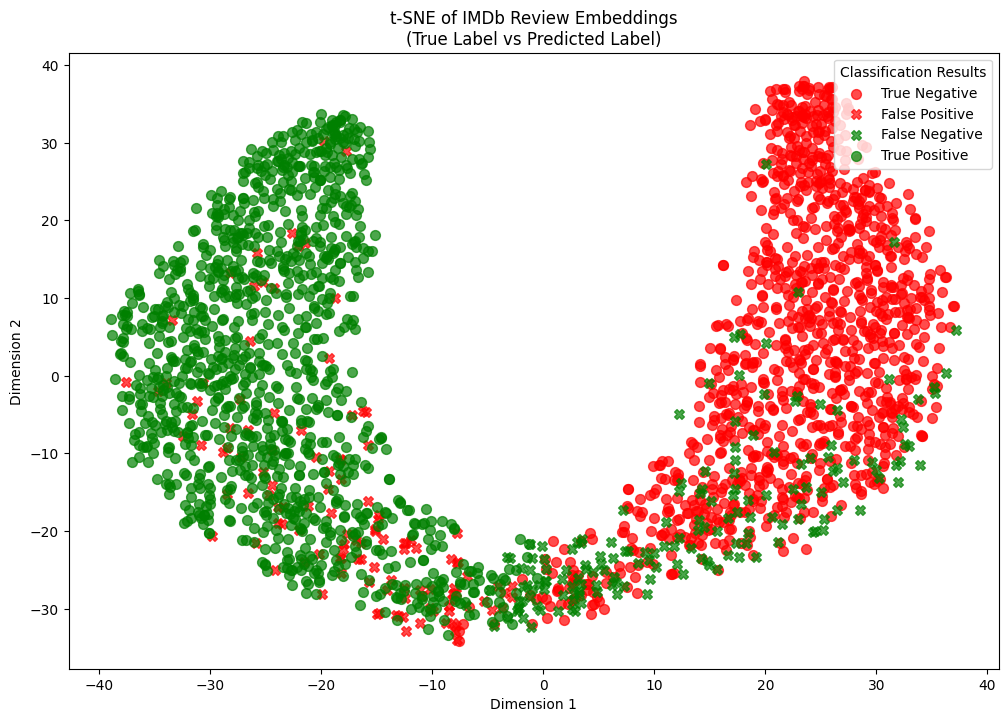

In [ ]:
from sklearn.manifold import TSNE
def tsne_viz(embed, labels, preds=None, sample_n = 3000, **kwargs):
  '''
  embed: tensor of embeddings, can be extract from model (dataset)
  labels: true labels
  preds: predicted labels (optional, if None, only plot true labels)
  sample_n: number of samples to visualize, if the dataset is smaller than this number, use all samples
  '''
  embeddings = np.array(embed)
  labels = np.array(labels)

  # sample only a fraction a instances
  if embeddings.shape[0] > sample_n:
    sample_indices = np.random.choice(embeddings.shape[0], size = sample_n, replace=False)
    sampled_embeddings = embeddings[sample_indices]
    sampled_labels = labels[sample_indices]
    if preds is not None:
      sampled_preds = preds[sample_indices]
  else:
    sampled_embeddings = embeddings
    sampled_labels = labels
    if preds is not None:
      sampled_preds = preds

  print(f"Shape of extracted embeddings: {sampled_embeddings.shape}")

  # Run t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=30)
  emb_2d = tsne.fit_transform(sampled_embeddings)
  # plotting arguments:
  if "legned_title" in kwargs:
    legend_title = kwargs["legend_title"]
  else:
    legend_title = "Classification Results"


  # Plot based on whether predictions are provided
  if preds is None:
    # Simple plot with only true labels
    label_map = {0: "Negative", 1: "Positive"}
    label_names = [label_map[l] for l in sampled_labels]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], hue=label_names,
                    palette=["red", "green"], s=50, alpha=0.7)
    plt.title("t-SNE of IMDb Review Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title = legend_title)

  else:
    # Complex plot with true vs predicted labels (4 categories)
    combined_categories = []
    for true_label, pred_label in zip(sampled_labels, sampled_preds):
      if true_label == 0 and pred_label == 0:
        combined_categories.append("True Neg / Pred Neg")
      elif true_label == 0 and pred_label == 1:
        combined_categories.append("True Neg / Pred Pos")
      elif true_label == 1 and pred_label == 0:
        combined_categories.append("True Pos / Pred Neg")
      else:  # true_label == 1 and pred_label == 1
        combined_categories.append("True Pos / Pred Pos")

    plt.figure(figsize=(12, 8))

    # Define colors and markers for each combination
    category_styles = {
      "True Neg / Pred Neg": {"color": "red", "marker": "o", "label": "True Negative"},
      "True Neg / Pred Pos": {"color": "red", "marker": "X", "label": "False Positive"},
      "True Pos / Pred Neg": {"color": "green", "marker": "X", "label": "False Negative"},
      "True Pos / Pred Pos": {"color": "green", "marker": "o", "label": "True Positive"}
    }

    # Plot each category separately for better control
    for category, style in category_styles.items():
      mask = np.array(combined_categories) == category
      if np.any(mask):
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1],
                   c=style["color"], marker=style["marker"],
                   label=style["label"], alpha=0.7, s=50)

    plt.title("t-SNE of IMDb Review Embeddings\n(True Label vs Predicted Label)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title=legend_title, loc='upper right')

  if 'save_fig' in kwargs and kwargs['save_fig']:
    fnmae = "tsne_embeddings.png" if 'fnmae' not in kwargs else kwargs['fnmae']
    plt.savefig(fnmae)
  plt.show()

# tsne_viz(embs, references, save_fig = True)
tsne_viz(embs, references, preds)

## Inspect the misclassified samples
Lastly, we inspect some misclassified comments to see what kind of comments the model would fail and why.

In [ ]:
tokenized_sample = tokenized_sample.add_column("preds", preds)
tokenized_sample = tokenized_sample.add_column("confidences", confidences)
# Inspect the misclassified
misclassified_instances = tokenized_sample.filter(lambda x: x['labels'] != x['preds'])
misclassified_neg_instances = misclassified_instances.filter(lambda x: x['labels'] == 0)
misclassified_pos_instances = misclassified_instances.filter(lambda x: x['labels'] == 1)

print(f"Number of misclassified negative instances: {len(misclassified_neg_instances)}")
print(f"Number of misclassified positive instances: {len(misclassified_pos_instances)}")

Number of misclassified negative instances: 121
Number of misclassified positive instances: 166


In [ ]:
from google.colab import data_table
import pandas as pd

# Show as an interactive table to inspect these misclassified
data_table.enable_dataframe_formatter()

# Convert the entire misclassified_instances dataset to a pandas DataFrame first
misclassified_df = misclassified_instances.to_pandas()

# sort by confidences
misclassified_df['confidences'] = misclassified_df['confidences'].astype(float).round(4)
misclassified_df.sort_values(by='confidences', ascending=False, inplace=True)

# Select the desired columns and display the DataFrame using data_table.DataTable
data_table.DataTable(
    misclassified_df[['text', 'labels', 'preds', 'confidences']],
    include_index=True,
    num_rows_per_page=10 # Set number of rows per page
)

,text,labels,preds,confidences
9,I really liked this quirky movie. The characte...,0,1,0.9999
140,This movie was pure genius. John Waters is bri...,0,1,0.9999
155,"I enjoyed this series, but felt that the whole...",1,0,0.9998
152,This film features two of my favorite guilty p...,0,1,0.9997
39,Check out the two octogenarians who review Lea...,0,1,0.9997
...,...,...,...,...
186,Some people think this was a rather bad TV ser...,1,0,0.5344
134,I like a lot of Myrna Loy movies. This film wa...,0,1,0.5299
203,Just see it! It's a smart movie but too hard t...,1,0,0.5244
178,People seem to be expecting Citizen Kane here!...,1,0,0.5104


It seems like some of these misclassified comments are mixed—partly positive and partly negative.

For example, in the `index 2` comment, the reviewer points out some of its flaws (or echoes negative remarks from others), but in the end, they still think it's great—or at least not too bad. They also mention that this opinion may be highly personal and that their taste might not align with everyone else's. Missification may stem from the strong words used in the sentence.
 - Not sure whether this case would only happen on misclassifed positive comments also on the negative ones.

Also some labels are potentially wrong as I inspect them I would make the same prediction as the model. (see `index 9` comments with a very high confidence)

## Other Thoughts

For future improvements, several areas could be enhanced:

- **t-SNE**: An interactive plot (possibly using the `plotly` package) could be added, allowing users to inspect each comment by hovering or clicking with the mouse to reveal the corresponding text.
  - Since th embeddings are high-dimension, perform PCA before t-SNE may possibly make the results more stable.
  - Or other dimenion-reduction tricks (e.g., UMAP or other manifold learning) can be used.

- Does the classifier misclassifies more on positive (or negative) comments?
  - Currently, there're more false negative (13%) than false positive (10%) for current dataset.
  - If we futher finetune on the IMDB dataset, would it boost the performance?
- Does the confidence really reflect how a certain instance more similar to one category to another.
  - That is, for a low-confident instance, does it means that the comment are not so alike the positve/negative one. It may be a mixture b/t these sentiments?